In [21]:
import matplotlib.pyplot as plt
import re

# Read the data from the file
with open('./../data/GEO/minipatch/frequency_results.txt', 'r') as f:
    data = f.read()

# Parse the data
folds = re.findall(r'Fold (\d+):(.*?)(?=Fold|\Z)', data, re.DOTALL)


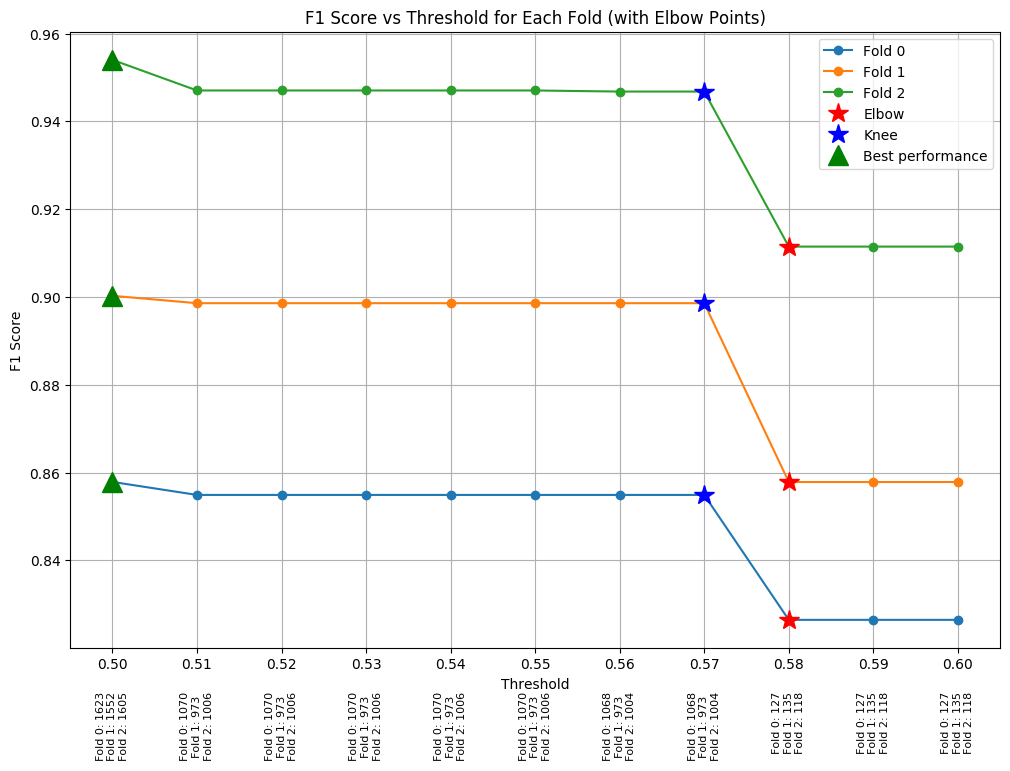

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def find_elbow(x_actual, y_actual):
    # Normalize the data
    x = (x_actual - np.min(x_actual)) / (np.max(x_actual) - np.min(x_actual))
    y = (y_actual - np.min(y_actual)) / (np.max(y_actual) - np.min(y_actual))
    
    # Calculate the angle for each point
    npoints = len(x)
    angles = np.zeros(npoints - 2)
    for i in range(1, npoints - 1):
        x1, y1 = x[i] - x[i-1], y[i] - y[i-1]
        x2, y2 = x[i+1] - x[i], y[i+1] - y[i]
        angles[i-1] = np.arctan2(x1*y2 - y1*x2, x1*x2 + y1*y2)
    
    # Find the point of maximum curvature
    elbow_index = np.argmax(angles) + 1
    return x_actual[elbow_index], y_actual[elbow_index]

def find_knee(x_actual, y_actual):
    # Normalize the data
    x = (x_actual - np.min(x_actual)) / (np.max(x_actual) - np.min(x_actual))
    y = (y_actual - np.min(y_actual)) / (np.max(y_actual) - np.min(y_actual))
    
    first = np.array([x[0], y[0]])
    last = np.array([x[-1], y[-1]])
    line_vec = last - first
    point_vec = np.array([x, y]).T - first
    distances = np.abs(np.cross(line_vec, point_vec)) / np.linalg.norm(line_vec)
    
    # The knee is the point with the maximum distance
    knee_index = np.argmax(distances)
    return x_actual[knee_index], y_actual[knee_index]

# In your main code:
elbow_points = {}
knee_points = {}

plt.figure(figsize=(12, 8))

for fold, fold_data in folds:
    thresholds = []
    f1_scores = []
    
    # Extract threshold and F1 score for each threshold in the fold
    for match in re.finditer(r'Threshold: ([\d.]+).*?F1 score: ([\d.]+)', fold_data, re.DOTALL):
        threshold, f1_score = match.groups()
        thresholds.append(float(threshold))
        f1_scores.append(float(f1_score))
        
    # Find the elbow point
    elbow_x, elbow_y = find_elbow(np.array(thresholds), np.array(f1_scores))
    elbow_points[fold] = elbow_x
    
    # Find the knee point
    knee_x, knee_y = find_knee(np.array(thresholds), np.array(f1_scores))
    knee_points[fold] = knee_x
    
    # Plot the data for this fold
    plt.plot(thresholds, f1_scores, marker='o', label=f'Fold {fold}')
    
    # Mark the elbow point
    elbow_x = elbow_points[fold]
    elbow_y = f1_scores[thresholds.index(elbow_x)]
    plt.plot(elbow_x, elbow_y, 'r*', markersize=15, label=f'Elbow' if fold == '2' else '')
    
    plt.plot(knee_x, knee_y, 'b*', markersize=15, label=f'Knee' if fold == '2' else '')
    
    # Mark the best threshold
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    plt.plot(best_threshold, best_f1, 'g^', markersize=15, label=f'Best performance' if fold == '2' else '')



plt.xlabel('Threshold')
plt.xticks(thresholds)
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold for Each Fold (with Elbow Points)')
plt.legend()
plt.grid(True)

# Add number of probes for each fold below x-axis
for i, threshold in enumerate(thresholds):
    probe_counts = []
    for fold, fold_data in folds:
        match = re.search(f'Threshold: {threshold}.*?Number of probes: (\d+)', fold_data, re.DOTALL)
        if match:
            probe_counts.append(f"Fold {fold}: {match.group(1)}")
    plt.text(threshold, plt.ylim()[0] - 0.01, '\n'.join(probe_counts), 
             ha='center', va='top', fontsize=8, rotation=90)

plt.show()
